# Dimension Reduction

http://web.stanford.edu/class/cs168/p2.pdf

In [8]:
import csv
import numpy as np

NUM_WORDS = 61067
NUM_ARTICLES = 1000
NUM_GROUPS = 20

articles = np.zeros(shape=(NUM_ARTICLES, NUM_WORDS))
article_groups = []
group_articles = []
for i in range(NUM_GROUPS):
    group_articles.append([])
    
with open('data/p2/data50.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        article = int(row[0]) - 1
        word = int(row[1]) - 1
        count = int(row[2])
        articles[article][word] = count

with open('data/p2/groups.csv') as file:
    groups = [l.strip() for l in file.readlines()]

with open('data/p2/label.csv') as file:
    article = 0
    for line in file:
        group = int(line) - 1
        article_groups.append(group)
        group_articles[group].append(article)
        article += 1

In [13]:
import math

def get_nearest(data, target_row):
    target_norm = np.linalg.norm(data[target_row]).item()
    best, best_id = -1, -1
    for (i, row) in enumerate(data):
        if i == target_row:
            continue
        dt = np.dot(data[target_row], row).item()
        row_norm = np.linalg.norm(row).item()
        cos_sim = dt / (row_norm * target_norm)
        if cos_sim > best:
            best = cos_sim
            best_id = i
    return best_id

def get_nearest_list(data):
    res = np.empty(shape=(data.shape[0]), dtype=int)
    for i in range(len(data)):
        res[i] = get_nearest(data, i)
    return res

nearest_list_baseline = get_nearest_list(articles)

In [33]:
def reduce_dimensions(target_d):
    projection = np.random.normal(0, 1, size=(NUM_WORDS, target_d))
    return np.matmul(articles, projection)

DIMENSIONS = [10, 25, 50, 100]

nearest_lists = {}
for d in DIMENSIONS:
    reduced = reduce_dimensions(d)
    nearest_lists[d] = get_nearest_list(reduced)

Accuracy (Baseline): 0.456


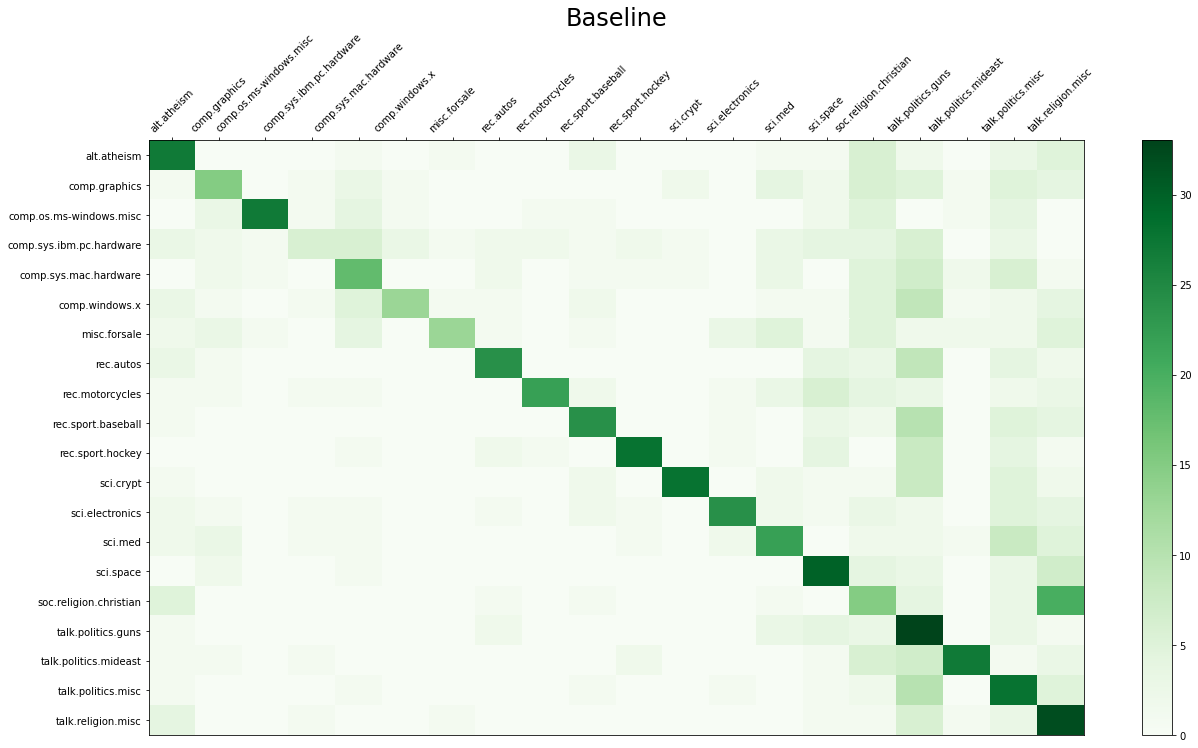

Accuracy (10-dim): 0.113


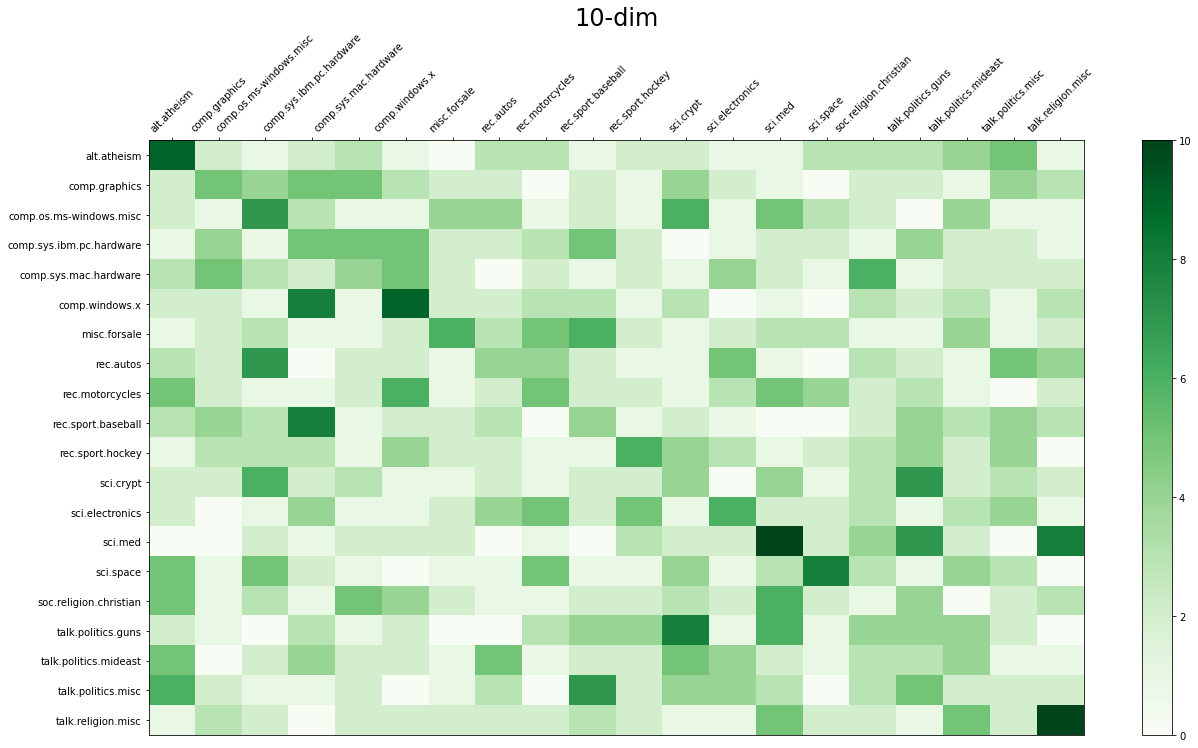

Accuracy (25-dim): 0.218


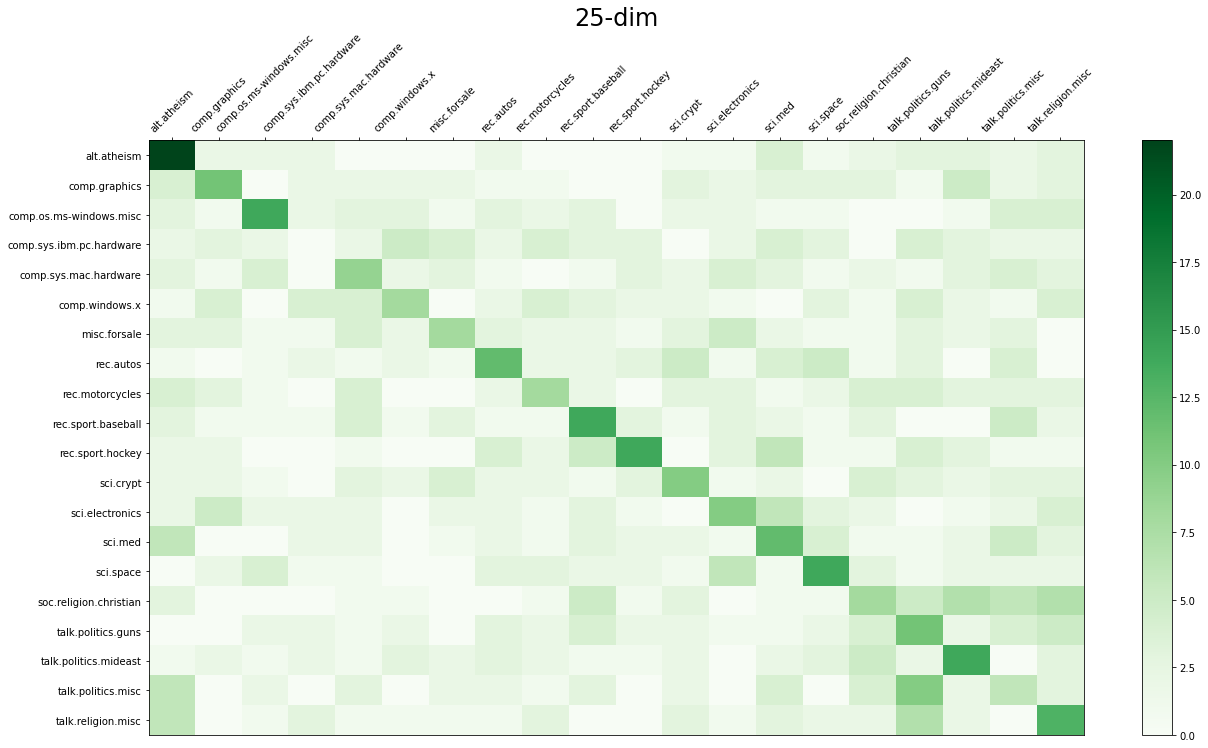

Accuracy (50-dim): 0.299


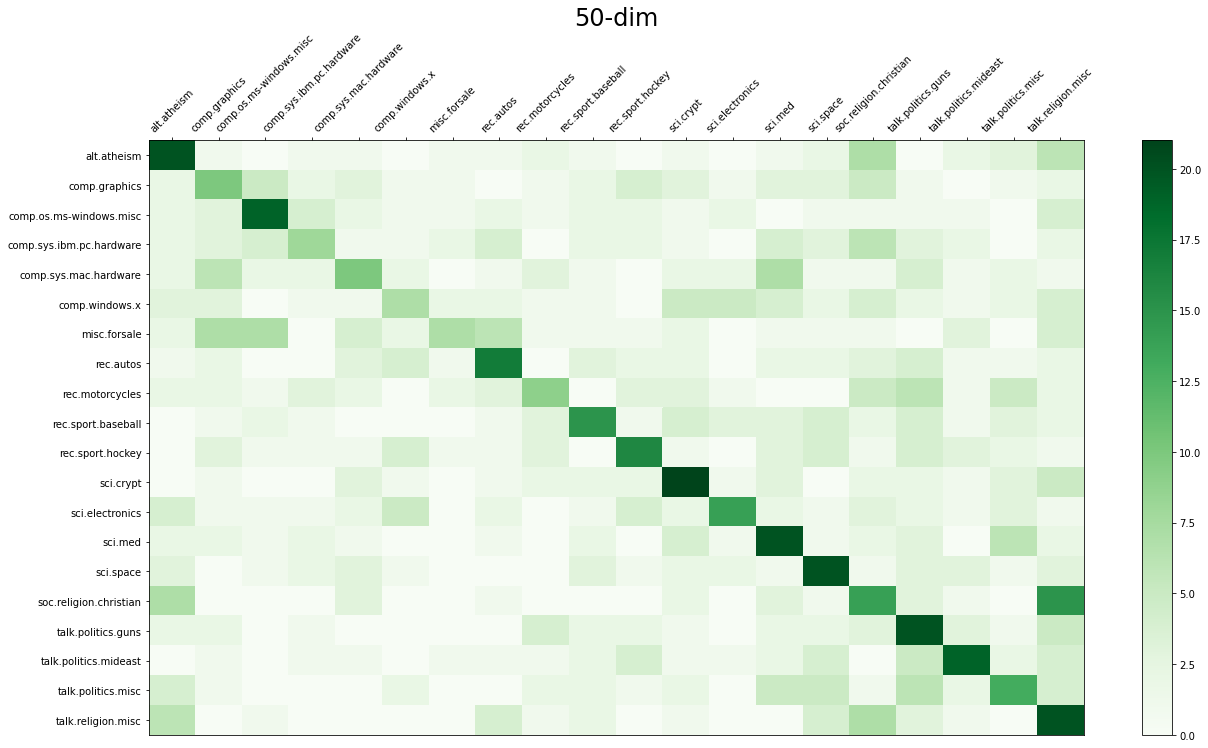

Accuracy (100-dim): 0.365


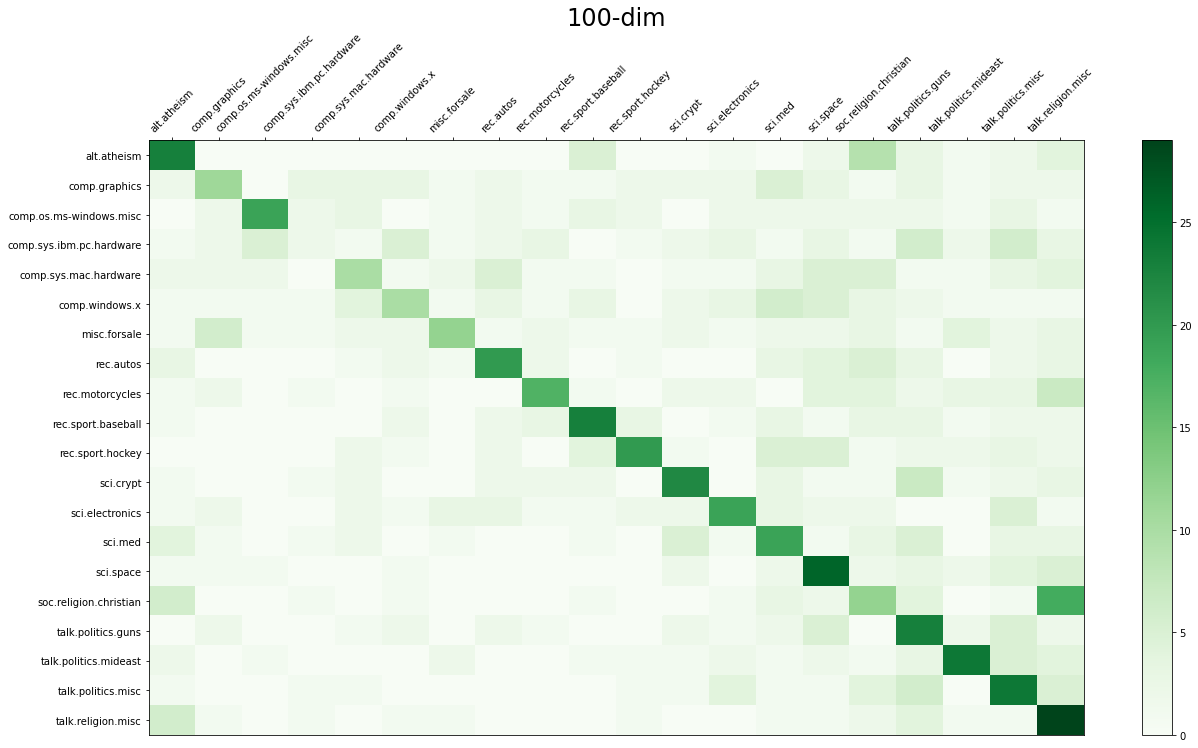

In [34]:
import matplotlib.pyplot as plt
import warnings

def to_heat_matrix(nearest_list, title):
    res = np.zeros(shape=(NUM_GROUPS, NUM_GROUPS), dtype=int)
    matches = 0
    for i in range(NUM_ARTICLES):
        true_group = article_groups[i]
        nearest_group = article_groups[nearest_list[i]]
        res[true_group][nearest_group] += 1
        if true_group == nearest_group:
            matches += 1
    acc = matches / NUM_ARTICLES
    print(f'Accuracy ({title}): {acc}')
    return res

# Mostly borrowed from http://web.stanford.edu/class/cs168/makeHeatMap.py
def makeHeatMap(data, names, title):
    #to catch "falling back to Agg" warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        #code source: http://stackoverflow.com/questions/14391959/heatmap-in-matplotlib-with-pcolor
        fig, ax = plt.subplots()
        plt.title(title, fontsize=24)
        fig.set_size_inches(18.5, 10.5)

        #create the map w/ color bar legend
        heatmap = ax.pcolor(data, cmap='Greens')
        cbar = plt.colorbar(heatmap)
        
        # put the major ticks at the middle of each cell
        ax.set_xticks(np.arange(data.shape[0])+0.5, minor=False)
        ax.set_yticks(np.arange(data.shape[1])+0.5, minor=False)

        # want a more natural, table-like display
        ax.invert_yaxis()
        ax.xaxis.tick_top()

        ax.set_xticklabels(names, rotation = 45)
        ax.set_yticklabels(names)

        plt.tight_layout()

        plt.show()
        plt.close()

makeHeatMap(to_heat_matrix(nearest_list_baseline, 'Baseline'), groups, 'Baseline')
for d in DIMENSIONS:
    title = f'{d}-dim'
    makeHeatMap(to_heat_matrix(nearest_lists[d], title), groups, title)

*Suppose you are trying to build a very fast article classification system, and have an enormous dataset of n labeled tweets/articles. What is the time it takes to reduce the dimensionality of the data? Give the Big-Oh runtime as a function of n (the number of labeled datapoints), k (the original dimension of each datapoint), and d (the reduced dimension).*

Generating random matrix: O(k * d) - assuming we can generate a random Gaussian in O(1).
Multiplying the matrices: O(n * k * d).

*What is the overall Big-Oh runtime of classifying a new article? Feel free to assume a naive matrix multiplication algorithm, as opposed to “fast matrix multiplication” algorithms, such as Strassen’s algorithm.*

Reduce the dimension: O(d * k).
Find nearest neighbor: O(n * d).
Total: O(d * (n + k))

*Now  suppose  you  are  instead  trying  to  classify  tweets;  the  bag-of-words  representation  is  still  a k-dimensional vector, but now each tweet has, say, only 50 << k words.  Explain how you could exploit the sparsity of the data to improve the runtime of the naive cosine-similarity nearest-neighbor classification system (from part (a)).*

Store the vectors sparsely (list of word-count tuples). Then cosine-similarity can be calculated in O(len-of-tweet) = O(d). Then can classify a tweet in O(n * d).